In [2]:
from src.tests import *

# Experiment 2
## Thompson

In [3]:
test_result_mab_2 = TestResult2Processing(folder="Thompson/Experiment2/", test_type="thompson")
results_mab_2 = test_result_mab_2.run()
results_mab_2_fp = results_mab_2.query("mde == '0'")
results_mab_2_fn = results_mab_2.query("mde != '0'")

results_mab_2_fn.unstack(level='multi_armed').to_excel(
    "Description experiment results/Conversion/Experiment2/thompson_FN.xlsx")
results_mab_2_fp.unstack(level='multi_armed').to_excel(
    "Description experiment results/Conversion/Experiment2/thompson_FP.xlsx")

  0%|          | 0/720 [00:00<?, ?it/s]

In [21]:
results_mab_2_fn.unstack(level='multi_armed')

count_winners  \
multi_armed                                                                            False   
p_control mde prob_super batch_size_share_mu method_update_params                              
1         10  0.9        0.01                normalization         {1: 593, -1: 110, 0: 297}   
                                             summation              {1: 620, -1: 65, 0: 315}   
                         0.02                normalization         {1: 654, -1: 129, 0: 217}   
                                             summation              {1: 698, -1: 59, 0: 243}   
                         0.03                normalization         {1: 696, -1: 142, 0: 162}   
...                                                                                      ...   
6         5   0.95       0.08                summation              {1: 770, 0: 85, -1: 145}   
                         0.09                normalization          {1: 708, -1: 254, 0: 38}   
                                             summation              {1: 769, 0: 64, -1: 167}   
                         0.1                 normalization          {1: 699, -1: 271, 0: 30}   
                                             summation              {1: 780, 0: 53, -1: 167}   

                                                                                              \
multi_armed                                                                             True   
p_control mde prob_super batch_size_share_mu method_update_params                              
1         10  0.9        0.01                normalization         {1: 518, -1: 242, 0: 240}   
                                             summation             {1: 524, -1: 243, 0: 233}   
                         0.02                normalization         {1: 546, -1: 271, 0: 183}   
                                             summation             {1: 576, -1: 229, 0: 195}   
                         0.03                normalization         {1: 601, -1: 256, 0: 143}   
...                                                                                      ...   
6         5   0.95       0.08                summation              {1: 602, -1: 370, 0: 28}   
                         0.09                normalization          {1: 595, -1: 376, 0: 29}   
                                             summation              {1: 621, -1: 351, 0: 28}   
                         0.1                 normalization          {1: 610, -1: 358, 0: 32}   
                                             summation              {1: 629, -1: 358, 0: 13}   

                                                                     size  \
multi_armed                                                         False   
p_control mde prob_super batch_size_share_mu method_update_params           
1         10  0.9        0.01                normalization         163091   
                                             summation             163091   
                         0.02                normalization         163091   
                                             summation             163091   
                         0.03                normalization         163091   
...                                                                   ...   
6         5   0.95       0.08                summation             100667   
                         0.09                normalization         100667   
                                             summation             100667   
                         0.1                 normalization         100667   
                                             summation             100667   

                                                                           \
multi_armed                                                          True   
p_control mde prob_super batch_size_share_mu method_update_params           
1         10  0.9        0.01                normalization         163091   
  

In [19]:
results_mab_2_fn.query("multi_armed=='True'").sort_values("share_test_winner", ascending=False)

count_winners  \
p_control mde prob_super batch_size_share_mu method_update_params multi_armed                              
1         5   0.9        0.1                 summation            True          {1: 767, -1: 206, 0: 27}   
          10  0.9        0.1                 summation            True          {1: 760, -1: 207, 0: 33}   
6         10  0.9        0.1                 summation            True          {1: 760, -1: 207, 0: 33}   
                         0.09                summation            True          {1: 746, -1: 209, 0: 45}   
1         10  0.9        0.09                summation            True          {1: 746, 0: 60, -1: 194}   
...                                                                                                  ...   
              0.95       0.01                normalization        True         {1: 431, -1: 353, 0: 216}   
11        5   0.95       0.01                normalization        True         {-1: 366, 1: 424, 0: 210}   
          10  0.95       0.01                summation            True         {1: 420, -1: 385, 0: 195}   
6         5   0.95       0.01                summation            True         {-1: 385, 1: 419, 0: 196}   
11        5   0.95       0.01                summation            True         {-1: 407, 1: 408, 0: 185}   

                                                                                 size  \
p_control mde prob_super batch_size_share_mu method_update_params multi_armed           
1         5   0.9        0.1                 summation            True         637007   
          10  0.9        0.1                 summation            True         163091   
6         10  0.9        0.1                 summation            True          25736   
                         0.09                summation            True          25736   
1         10  0.9        0.09                summation            True         163091   
...                                                                               ...   
              0.95       0.01                normalization        True         163091   
11        5   0.95       0.01                normalization        True          51908   
          10  0.95       0.01                summation            True          13249   
6         5   0.95       0.01                summation            True         100667   
11        5   0.95       0.01                summation            True          51908   

                                                                              share_observations_mean  \
p_control mde prob_super batch_size_share_mu method_update_params multi_armed                           
1         5   0.9        0.1                 summation            True                 [0.438, 0.655]   
          10  0.9        0.1                 summation            True                   [0.45, 0.66]   
6         10  0.9        0.1                 summation            True                 [0.459, 0.654]   
                         0.09                summation            True                 [0.453, 0.631]   
1         10  0.9        0.09                summation            True                 [0.445, 0.628]   
...                                                                                               ...   
              0.95       0.01                normalization        True                  [0.53, 0.725]   
11        5   0.95       0.01                normalization        True                 [0.556, 0.732]   
          10  0.95       0.01                summation            True                 [0.544, 0.732]   
6         5   0.95       0.01                summation            True                 [0.572, 0.731]   
11        5   0.95       0.01                summation            True                 [0.599, 0.737]   

                                                                              share_observations_median  \
p_control mde prob_super batch_size_share_mu method_upd

# Experiment 3
## Thompson

In [5]:
test_result_mab_3 = TestResult2Processing(folder="Thompson/Experiment3/", test_type="thompson")
results_mab_3 = test_result_mab_3.run()
results_mab_3_fp = results_mab_3.query("mde == '0'")
results_mab_3_fn = results_mab_3.query("mde != '0'")

  0%|          | 0/360 [00:00<?, ?it/s]

In [18]:
results_mab_3_fn.sort_values("share_test_winner", ascending=False)

count_winners  \
p_control mde prob_super batch_size_share_mu method_update_params multi_armed                              
1         5   0.9        0.1                 summation            False         {1: 779, -1: 184, 0: 37}   
6         10  0.9        0.1                 summation            False         {1: 766, -1: 194, 0: 40}   
1         5   0.9        0.08                summation            False         {1: 762, -1: 182, 0: 56}   
                         0.09                summation            False         {1: 758, -1: 197, 0: 45}   
          10  0.9        0.1                 summation            False         {1: 747, -1: 206, 0: 47}   
...                                                                                                  ...   
11        10  0.95       0.01                summation            True         {1: 370, -1: 504, 0: 126}   
6         10  0.95       0.01                summation            True         {-1: 498, 1: 368, 0: 134}   
1         5   0.95       0.01                summation            True         {1: 366, 0: 133, -1: 501}   
          10  0.95       0.01                summation            True         {1: 364, -1: 520, 0: 116}   
6         5   0.95       0.01                summation            True         {-1: 523, 1: 350, 0: 127}   

                                                                                 size  \
p_control mde prob_super batch_size_share_mu method_update_params multi_armed           
1         5   0.9        0.1                 summation            False        637007   
6         10  0.9        0.1                 summation            False         25736   
1         5   0.9        0.08                summation            False        637007   
                         0.09                summation            False        637007   
          10  0.9        0.1                 summation            False        163091   
...                                                                               ...   
11        10  0.95       0.01                summation            True          13249   
6         10  0.95       0.01                summation            True          25736   
1         5   0.95       0.01                summation            True         637007   
          10  0.95       0.01                summation            True         163091   
6         5   0.95       0.01                summation            True         100667   

                                                                              share_observations_mean  \
p_control mde prob_super batch_size_share_mu method_update_params multi_armed                           
1         5   0.9        0.1                 summation            False                [1.053, 1.053]   
6         10  0.9        0.1                 summation            False                [1.055, 1.055]   
1         5   0.9        0.08                summation            False                [1.043, 1.043]   
                         0.09                summation            False                  [1.05, 1.05]   
          10  0.9        0.1                 summation            False                [1.056, 1.056]   
...                                                                                               ...   
11        10  0.95       0.01                summation            True                  [0.69, 1.321]   
6         10  0.95       0.01                summation            True                 [0.702, 1.309]   
1         5   0.95       0.01                summation            True                 [0.688, 1.323]   
          10  0.95       0.01                summation            True                 [0.685, 1.327]   
6         5   0.95       0.01                summation            True                 [0.698, 1.314]   

                                                                              share_observations_median  \
p_control mde prob_super batch_size_share_mu method_upd

# Compare experiments 

## Thompson

In [8]:
results_mab_3_fp[['share_not_winner']].join(
results_mab_2_fp[['share_not_winner']], rsuffix='_exp2', lsuffix='_exp3')

share_not_winner_exp3  \
p_control mde prob_super batch_size_share_mu method_update_params multi_armed                          
11        0   0.9        0.01                summation            True                         0.359   
1         0   0.9        0.07                summation            True                         0.513   
6         0   0.9        0.01                summation            True                         0.354   
                         0.06                summation            False                        0.330   
                         0.01                summation            False                        0.135   
...                                                                                              ...   
11        0   0.95       0.1                 summation            False                        0.492   
1         0   0.9        0.01                summation            True                         0.222   
11        0   0.9        0.05                summation            False                        0.306   
              0.95       0.06                summation            False                        0.411   
                         0.03                summation            False                        0.281   

                                                                               share_not_winner_exp2  
p_control mde prob_super batch_size_share_mu method_update_params multi_armed                         
11        0   0.9        0.01                summation            True                         0.216  
1         0   0.9        0.07                summation            True                         0.322  
6         0   0.9        0.01                summation            True                         0.211  
                         0.06                summation            False                        0.165  
                         0.01                summation            False                        0.033  
...                                                                                              ...  
11        0   0.95       0.1                 summation            False                        0.329  
1         0   0.9        0.01                summation            True                         0.171  
11        0   0.9        0.05                summation            False                        0.148  
              0.95       0.06                summation            False                        0.246  
                         0.03                summation            False                        0.154  

[120 rows x 2 columns]

In [16]:
results_mab_3_fn[['share_test_winner']].join(
results_mab_2_fn[['share_test_winner']], rsuffix='_exp2', lsuffix='_exp3').\
sort_values("share_test_winner_exp3", ascending=False).iloc[60:120]

share_test_winner_exp3  \
p_control mde prob_super batch_size_share_mu method_update_params multi_armed                           
1         10  0.9        0.03                summation            False                         0.669   
          5   0.95       0.05                summation            False                         0.668   
6         5   0.9        0.04                summation            False                         0.668   
              0.95       0.05                summation            False                         0.667   
1         10  0.95       0.06                summation            False                         0.666   
6         5   0.95       0.06                summation            False                         0.666   
11        5   0.95       0.06                summation            False                         0.666   
1         10  0.95       0.08                summation            False                         0.665   
11        10  0.95       0.08                summation            False                         0.664   
1         10  0.95       0.05                summation            False                         0.663   
          5   0.9        0.04                summation            False                         0.659   
          10  0.9        0.1                 summation            True                          0.658   
          5   0.9        0.1                 summation            True                          0.658   
6         10  0.9        0.03                summation            False                         0.656   
              0.95       0.05                summation            False                         0.654   
11        5   0.9        0.04                summation            False                         0.652   
6         10  0.95       0.06                summation            False                         0.652   
1         10  0.95       0.04                summation            False                         0.652   
11        10  0.9        0.04                summation            False                         0.646   
1         10  0.95       0.03                summation            False                         0.644   
6         10  0.95       0.04                summation            False                         0.644   
11        10  0.95       0.07                summation            False                         0.643   
          5   0.95       0.05                summation            False                         0.641   
1         5   0.95       0.04                summation            False                         0.641   
6         10  0.9        0.1                 summation            True                          0.640   
1         10  0.9        0.02                summation            False                         0.640   
6         5   0.9        0.02                summation            False                         0.639   
                         0.03                summation            False                         0.639   
                         0.1                 summation            True                          0.638   
11        10  0.95       0.06                summation            False                         0.638   
1         5   0.9        0.09                summation            True                          0.635   
6         5   0.95       0.04                summation            False                         0.634   
          10  0.9        0.09                summation            True                          0.634   
1         10  0.9        0.09                summation            True                          0.633   
11        10  0.9        0.03                summation            False                         0.631   
              0.95       0.05                summation            False                         0.630   
          5   0.9        0.1                 summation            True                   

In [ ]:
# test_result_mab = TestResult1Processing(folder="Thompson/Experiment1/",
#                                         test_type="thompson")
# test_result_bayes = TestResult1Processing(folder="Bayesian/Experiment1/",
#                                           test_type="bayesian")
# test_result_mab = TestResult1Processing(folder="Thompson/Experiment2/",
#                                         test_type="thompson")
# test_result2_bayes = TestResult2Processing(folder="Bayesian/Experiment2/",
#                                            test_type="bayesian")

# results_bayes = test_result_bayes.run()
# results_bayes_fp = results_bayes.query("mde == '0'")

# # # results_bayes_fn = results_bayes.query("mde != '0'")
# results2_bayes = test_result2_bayes.run()
# results2_bayes_fp = results2_bayes.query("mde == '0'")
# results2_bayes_fn = results2_bayes.query("mde != '0'")
# results2_bayes_fp.reset_index()[
#     ['share_observation_optimal_arms', 'share_not_winner']
# ].astype(float).corr()
# n_samples = results2_bayes_fn[['share_test_winner']].unstack()
# n_samples_fp = results2_bayes_fp[['share_not_winner']].unstack()



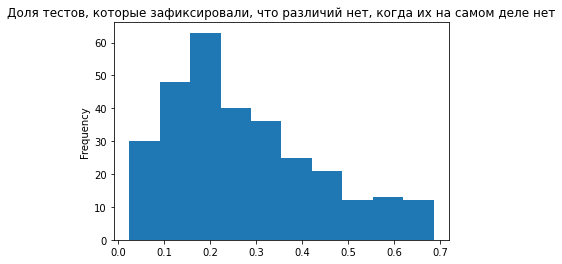

In [80]:
thompson_results_df.query("mde == '0'")['share_not_winner'].plot(kind='hist');
plt.title("Доля тестов, которые зафиксировали, что различий нет, когда их на самом деле нет");

In [95]:
plot_df = thompson_results_df.query("""mde == '0' & multi_armed == 'True'""").reset_index()[
    ['share_not_winner', "prob_super",'batch_size_share_mu']].astype(float)
fig = px.scatter(plot_df, x="share_not_winner", y="prob_super", color="batch_size_share_mu")
fig.show()

In [103]:
plot_df = thompson_results_df.query("""mde != '0' & multi_armed == 'False'""").reset_index()[
    ["share_not_winner", 'share_test_winner', "prob_super",'batch_size_share_mu']].astype(float)
fig = px.scatter(plot_df, x="share_test_winner", y="prob_super", color="batch_size_share_mu")
fig.show()